# 1. Import libs

In [1]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm
import datetime

# Tensorflow
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

print("Import successfully")

Import successfully


In [ ]:
!unzip drive/MyDrive/x_ray*.zip

In [3]:
alexnet_file = 'drive/MyDrive/models/best_alexnet.hdf5'
vgg_file = 'drive/MyDrive/models/best_vgg16.hdf5'
resnet_file = 'drive/MyDrive/models/best_resnet18.hdf5'

In [4]:
input_folder = './x_ray_corona_dataset'
test_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')
train_img_folder = os.path.join(input_folder, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
metadata_df = pd.read_csv(os.path.join(input_folder, 'Chest_xray_Corona_Metadata.csv'), index_col=0)

# Split to train & test set
train_df = metadata_df[metadata_df.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata_df[metadata_df.Dataset_type == 'TEST'].reset_index(drop=True)

# Check train_df size + test_df size == metadata_df size
assert train_df.size + test_df.size == metadata_df.size

print(f'Shape of train data: { train_df.shape }')
print(f'Shape of test data: { test_df.shape }')

test_batches = ImageDataGenerator().flow_from_dataframe(test_df,
                                            directory=test_img_folder,
                                            x_col='X_ray_image_name',
                                            y_col='Label',
                                            class_mode='binary',
                                            batch_size=8,
                                            target_size=(224, 224),
                                            shuffle=False)

Shape of train data: (5286, 5)
Shape of test data: (624, 5)
Found 624 validated image filenames belonging to 2 classes.


In [5]:
test_img_name = os.path.join(train_img_folder, metadata_df.X_ray_image_name[0])
img = img_to_array(load_img(test_img_name).resize((224, 224)))
img = np.expand_dims(img, 0)
img = img / 255

In [8]:
resnet = load_model(resnet_file)
vgg = load_model(vgg_file)

In [9]:
layer_names = [layer.name for layer in resnet.layers[1].layers]
successive_outputs = [layer.output for layer in resnet.layers[1].layers[1:]]
visualization_model = Model(inputs = resnet.layers[1].input, outputs = successive_outputs)
feature_maps = visualization_model.predict(img)
block_to_display_fm_names = ['conv0', 'add_9', 'add_11', 'add_13', 'add_15']

In [10]:
def visualize_featuremaps(block_to_display, layer_names, feature_maps, name=None):
  idx = 0
  for layer_name, feature_map in zip(layer_names, feature_maps):
    if idx >= len(block_to_display_fm_names):
      break
    if layer_name == block_to_display_fm_names[idx]:
      n_features = feature_map.shape[-1]  
      size       = feature_map.shape[ 1] 
      display_grid = np.zeros((size, size * 6))

    
      for i in range(6):
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x

      scale = 20. / n_features
      plt.figure(figsize=(6, .8))
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(display_grid, aspect='auto', cmap='viridis')
      if name != None:
        plt.title(name[idx])
      else:
        plt.title(block_to_display_fm_names[idx])
      idx += 1
    else:
      continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


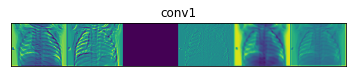

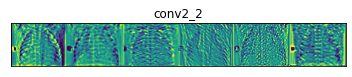

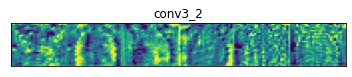

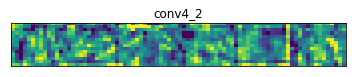

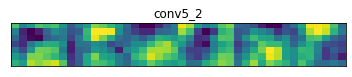

In [11]:
visualize_featuremaps(block_to_display_fm_names, layer_names, feature_maps, ['conv1', 'conv2_2', 'conv3_2', 'conv4_2', 'conv5_2'])

In [12]:
layer_names = [layer.name for layer in vgg.layers[1].layers]
successive_outputs = [layer.output for layer in vgg.layers[1].layers[1:]]
visualization_model = Model(inputs = vgg.layers[1].input, outputs = successive_outputs)
feature_maps = visualization_model.predict(img)
block_to_display_fm_names = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


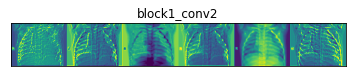

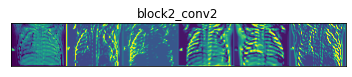

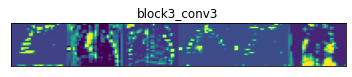

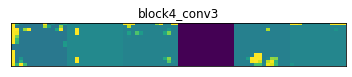

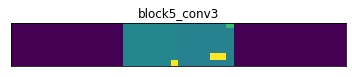

In [13]:
visualize_featuremaps(block_to_display_fm_names, layer_names, feature_maps)